In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

data_dir = '/content/drive/MyDrive/DATA-4380/Vision Project/raw'
files = os.listdir(data_dir)
print("Total images found:", len(files))
print("Example filenames:", files[:5])


Total images found: 10157
Example filenames: ['36_1_0_20170108230047374.jpg', '48_0_0_20170109012405234.jpg', '36_1_0_20170108224009217.jpg', '37_0_0_20170109015606661.jpg', '26_1_4_20170109002629914.jpg']


In [ ]:
import pandas as pd

valid_classes = [0, 1, 2, 3, 4]
data = []

for file in files:
    try:
        age, gender, race, _ = file.split("_", 3)
        race = int(race)
        if race in valid_classes:
            data.append({"filename": file, "race": race})
    except:
        continue

df = pd.DataFrame(data)
print("Filtered image count:", len(df))

# Sample ≤100 images per class
subset_df = df.groupby("race").apply(lambda x: x.sample(n=min(100, len(x)), random_state=42))
subset_df.reset_index(drop=True, inplace=True)
print(subset_df['race'].value_counts())


Filtered image count: 10155
race
0    100
1    100
2    100
3    100
4    100
Name: count, dtype: int64


/tmp/ipython-input-3-3525632696.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset_df = df.groupby("race").apply(lambda x: x.sample(n=min(100, len(x)), random_state=42))


In [ ]:
import shutil

output_base = '/content/utk_subset'
os.makedirs(output_base, exist_ok=True)

for race in valid_classes:
    os.makedirs(os.path.join(output_base, str(race)), exist_ok=True)

for _, row in subset_df.iterrows():
    src = os.path.join(data_dir, row['filename'])
    dst = os.path.join(output_base, str(row['race']), row['filename'])
    shutil.copy(src, dst)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15
)

train_generator = datagen.flow_from_directory(
    output_base,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    output_base,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)


Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


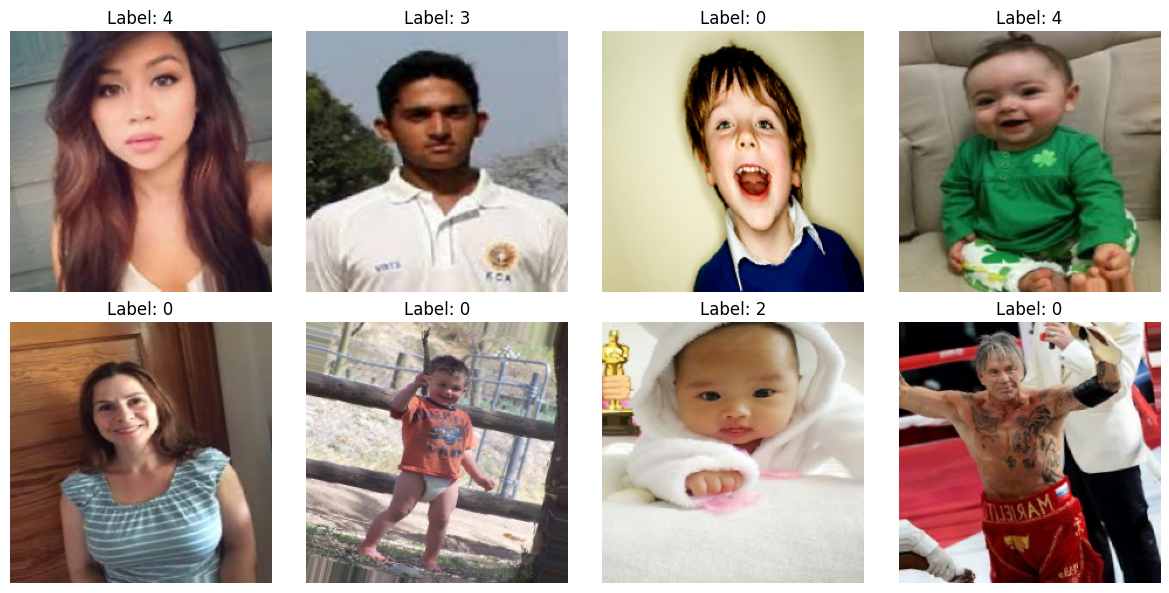

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(train_generator)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
# Load pretrained MobileNetV2 without top classifier
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)  # 5 classes

model = Model(inputs=base_model.input, outputs=predictions)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
epochs = 10  # You can increase this later
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4454 - loss: 1.4429 - val_accuracy: 0.3000 - val_loss: 1.5774
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.3720 - loss: 1.4434 - val_accuracy: 0.2700 - val_loss: 1.5885
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3964 - loss: 1.4094 - val_accuracy: 0.2900 - val_loss: 1.5632
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.3967 - loss: 1.4238 - val_accuracy: 0.3000 - val_loss: 1.5735
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3408 - loss: 1.4614 - val_accuracy: 0.3200 - val_loss: 1.5450
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.4274 - loss: 1.3567 - val_accuracy: 0.2800 - val_loss: 1.5438
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4766 - loss: 1.2904 - val_accuracy: 0.3000 - val_loss: 1.5228
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.4253 - loss: 1.3249 - val_accuracy: 0.3000 - val_loss:

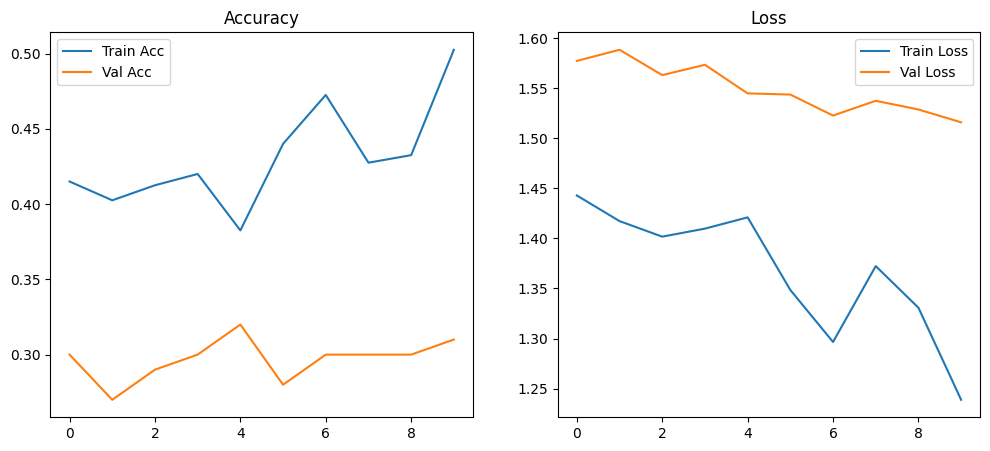

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/race_classifier_mobilenetv2.h5")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,            # Augmentation 1
    zoom_range=0.2,               # Augmentation 2
    horizontal_flip=True          # Augmentation 3
)

train_aug_gen = augmented_datagen.flow_from_directory(
    '/content/utk_subset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_aug_gen = augmented_datagen.flow_from_directory(
    '/content/utk_subset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)


Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


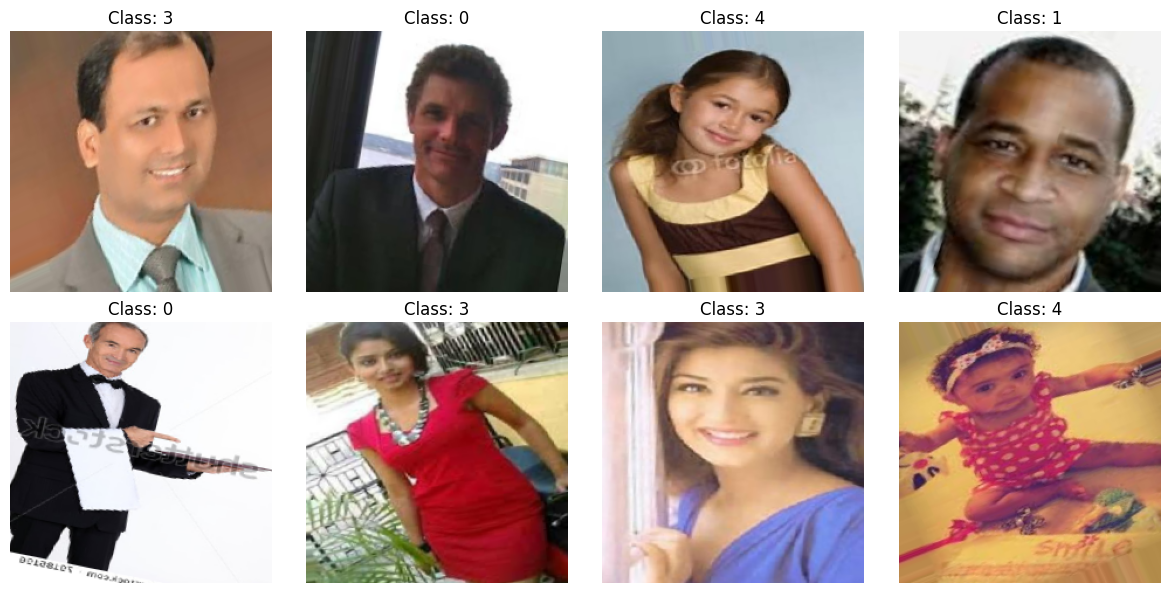

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(train_aug_gen)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.title(f"Class: {int(labels[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(5, activation='softmax')(x)

aug_model = Model(inputs=base_model.input, outputs=preds)
aug_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


In [ ]:
aug_history = aug_model.fit(
    train_aug_gen,
    validation_data=val_aug_gen,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2019 - loss: 2.4089

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.2037 - loss: 2.3941 - val_accuracy: 0.1600 - val_loss: 1.8463
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.1756 - loss: 2.0401 - val_accuracy: 0.2100 - val_loss: 1.7715
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.2603 - loss: 1.8432 - val_accuracy: 0.2200 - val_loss: 1.7511
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.2280 - loss: 1.8013 - val_accuracy: 0.2400 - val_loss: 1.6600
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2673 - loss: 1.7064 - val_accuracy: 0.2700 - val_loss: 1.6534
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.2850 - loss: 1.6596 - val_accuracy: 0.2800 - val_loss: 1.6120
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.2854 - loss: 1.6762 - val_accuracy: 0.2100 - val_loss: 1.6568
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.2737 - loss: 1.6577 - val_accuracy: 0.2200 - val_loss: 1.6211
Epo

In [ ]:
aug_model.save("/content/drive/MyDrive/race_model_with_augmentation.h5")


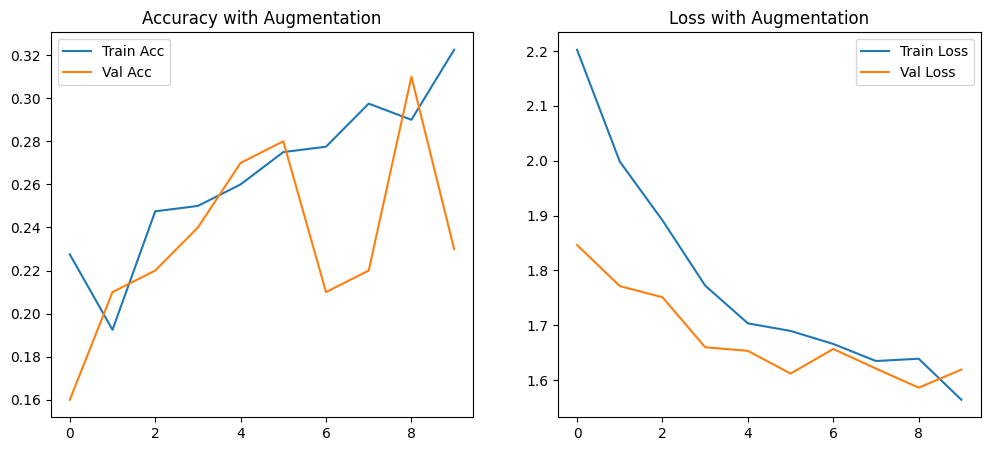

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(aug_history.history['accuracy'], label='Train Acc')
plt.plot(aug_history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy with Augmentation")

plt.subplot(1, 2, 2)
plt.plot(aug_history.history['loss'], label='Train Loss')
plt.plot(aug_history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss with Augmentation")

plt.show()


In [ ]:
from tensorflow.keras.models import load_model

baseline_model = load_model("/content/drive/MyDrive/race_classifier_mobilenetv2.h5")
aug_model = load_model("/content/drive/MyDrive/race_model_with_augmentation.h5")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = val_datagen.flow_from_directory(
    '/content/utk_subset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)


Found 100 images belonging to 5 classes.


In [ ]:
import numpy as np

# True labels
true_labels = val_gen.classes

# Baseline predictions
baseline_probs = baseline_model.predict(val_gen)
baseline_preds = np.argmax(baseline_probs, axis=1)

# Augmented model predictions
aug_probs = aug_model.predict(val_gen)
aug_preds = np.argmax(aug_probs, axis=1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step


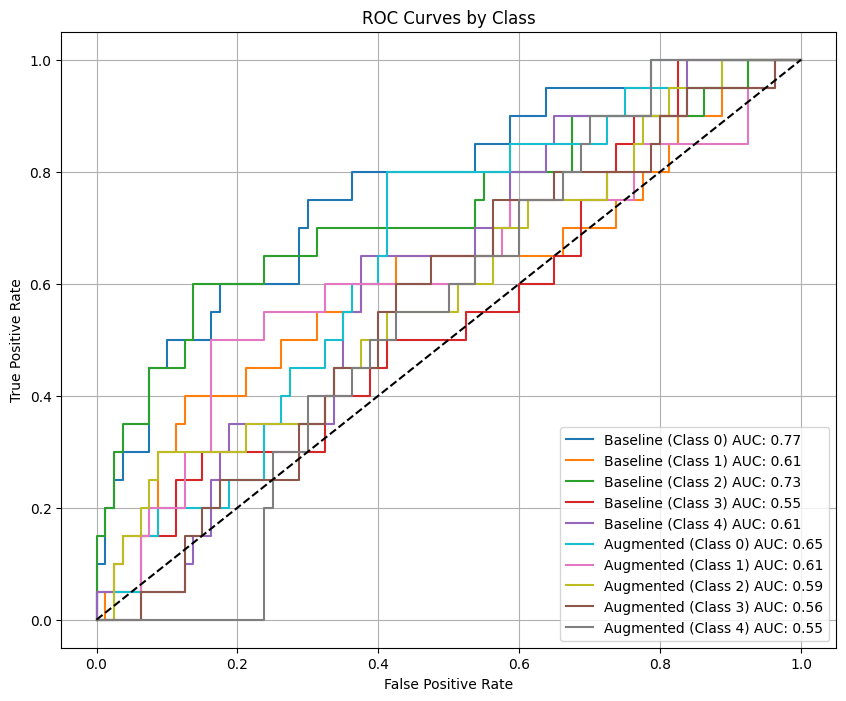

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Convert to one-hot labels
true_labels_onehot = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])

# Calculate ROC for each class
def plot_roc(y_true, y_scores, label, color):
    for i in range(5):  # 5 classes
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (Class {i}) AUC: {roc_auc:.2f}', color=color[i])

colors = [['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd'],  # baseline
          ['#17becf','#e377c2','#bcbd22','#8c564b','#7f7f7f']]  # augmented

plt.figure(figsize=(10, 8))
plot_roc(true_labels_onehot, baseline_probs, "Baseline", colors[0])
plot_roc(true_labels_onehot, aug_probs, "Augmented", colors[1])

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.title("ROC Curves by Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("Baseline Model Performance:\n")
print(classification_report(true_labels, baseline_preds))

print("Augmented Model Performance:\n")
print(classification_report(true_labels, aug_preds))


Baseline Model Performance:

              precision    recall  f1-score   support

           0       0.55      0.30      0.39        20
           1       0.33      0.35      0.34        20
           2       0.34      0.60      0.44        20
           3       0.18      0.15      0.16        20
           4       0.38      0.30      0.33        20

    accuracy                           0.34       100
   macro avg       0.35      0.34      0.33       100
weighted avg       0.35      0.34      0.33       100

Augmented Model Performance:

              precision    recall  f1-score   support

           0       0.29      0.20      0.24        20
           1       0.26      0.30      0.28        20
           2       0.26      0.35      0.30        20
           3       0.19      0.15      0.17        20
           4       0.15      0.15      0.15        20

    accuracy                           0.23       100
   macro avg       0.23      0.23      0.23       100
weighted avg      

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    '/content/utk_subset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    '/content/utk_subset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)


Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False  # Freeze base layers initially

x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(5, activation='softmax')(x)

resnet_model = Model(inputs=resnet_base.input, outputs=preds)

resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
resnet_history = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2509 - loss: 1.8355

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 100s 7s/step - accuracy: 0.2496 - loss: 1.8367 - val_accuracy: 0.2000 - val_loss: 1.6235
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 87s 7s/step - accuracy: 0.2151 - loss: 1.8661 - val_accuracy: 0.2300 - val_loss: 1.6203
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.1654 - loss: 1.8916 - val_accuracy: 0.2000 - val_loss: 1.6167
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.2035 - loss: 1.7676 - val_accuracy: 0.2100 - val_loss: 1.6199
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 87s 7s/step - accuracy: 0.1377 - loss: 1.8770 - val_accuracy: 0.2100 - val_loss: 1.6131
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.2230 - loss: 1.7404 - val_accuracy: 0.2300 - val_loss: 1.6131
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.2121 - loss: 1.7440 - val_accuracy: 0.2100 - val_loss: 1.6185
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.1678 - loss: 1.8077 - val_accuracy: 0.2000 - val_loss: 1.6175
E

In [ ]:
resnet_model.save("/content/drive/MyDrive/race_model_resnet50.h5")


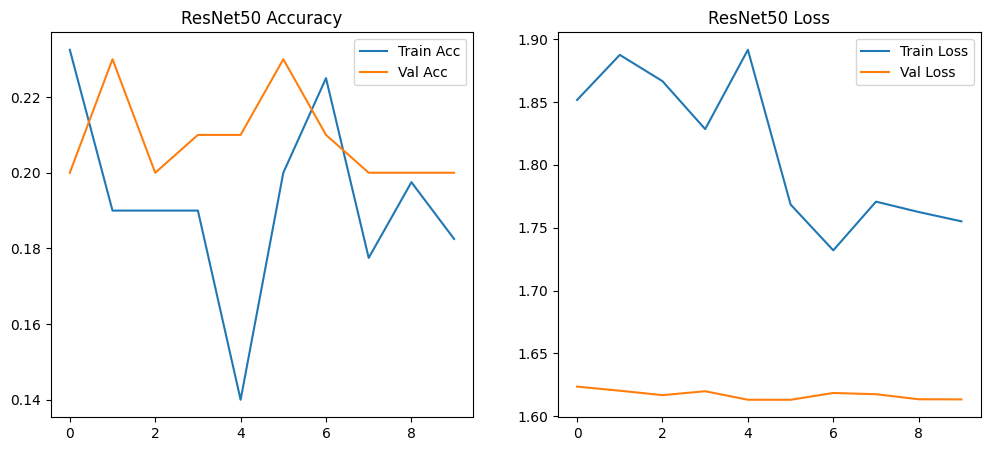

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'], label='Train Acc')
plt.plot(resnet_history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("ResNet50 Accuracy")

plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], label='Train Loss')
plt.plot(resnet_history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("ResNet50 Loss")

plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    '/content/utk_subset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    '/content/utk_subset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)


Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

eff_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
eff_base.trainable = False

x = eff_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(5, activation='softmax')(x)

eff_model = Model(inputs=eff_base.input, outputs=output)

eff_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
eff_history = eff_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2230 - loss: 1.6227

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.2210 - loss: 1.6232 - val_accuracy: 0.2000 - val_loss: 1.6102
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.2069 - loss: 1.6524 - val_accuracy: 0.2000 - val_loss: 1.6096
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.2070 - loss: 1.6339 - val_accuracy: 0.2100 - val_loss: 1.6100
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.1814 - loss: 1.6436 - val_accuracy: 0.2000 - val_loss: 1.6097
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.1778 - loss: 1.6232 - val_accuracy: 0.2000 - val_loss: 1.6099
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.1922 - loss: 1.6300 - val_accuracy: 0.2000 - val_loss: 1.6101
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.2001 - loss: 1.6172 - val_accuracy: 0.2000 - val_loss: 1.6103
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.2033 - loss: 1.6251 - val_accuracy: 0.2000 - val_loss: 1.6099
Epo

In [ ]:
eff_model.save("/content/drive/MyDrive/race_model_efficientnetb0.h5")


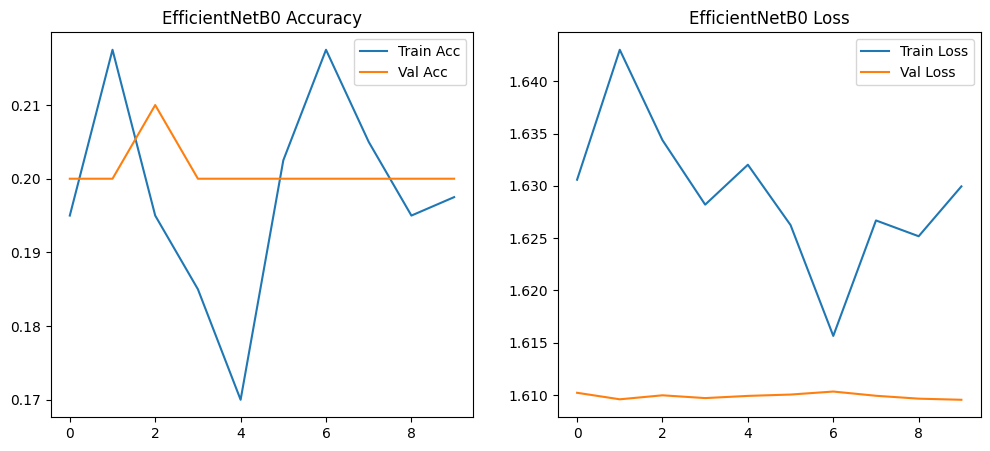

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(eff_history.history['accuracy'], label='Train Acc')
plt.plot(eff_history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("EfficientNetB0 Accuracy")

plt.subplot(1, 2, 2)
plt.plot(eff_history.history['loss'], label='Train Loss')
plt.plot(eff_history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("EfficientNetB0 Loss")

plt.show()


In [ ]:
from tensorflow.keras.models import load_model

baseline_model = load_model("/content/drive/MyDrive/race_classifier_mobilenetv2.h5")
resnet_model = load_model('/content/drive/MyDrive/race_model_resnet50.h5')
eff_model = load_model('/content/drive/MyDrive/race_model_efficientnetb0.h5')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = val_datagen.flow_from_directory(
    '/content/utk_subset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)


Found 100 images belonging to 5 classes.


In [ ]:
import numpy as np

true_labels = val_gen.classes
true_labels_onehot = tf.keras.utils.to_categorical(true_labels, num_classes=5)

baseline_probs = baseline_model.predict(val_gen)
resnet_probs = resnet_model.predict(val_gen)
eff_probs = eff_model.predict(val_gen)

baseline_preds = np.argmax(baseline_probs, axis=1)
resnet_preds = np.argmax(resnet_probs, axis=1)
eff_preds = np.argmax(eff_probs, axis=1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/4 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


In [ ]:
from sklearn.metrics import classification_report

print("📊 Baseline Model")
print(classification_report(true_labels, baseline_preds))

print("\n📊 ResNet50 Model")
print(classification_report(true_labels, resnet_preds))

print("\n📊 EfficientNetB0 Model")
print(classification_report(true_labels, eff_preds))


📊 Baseline Model
              precision    recall  f1-score   support

           0       0.55      0.30      0.39        20
           1       0.33      0.35      0.34        20
           2       0.34      0.60      0.44        20
           3       0.18      0.15      0.16        20
           4       0.38      0.30      0.33        20

    accuracy                           0.34       100
   macro avg       0.35      0.34      0.33       100
weighted avg       0.35      0.34      0.33       100


📊 ResNet50 Model
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        20
           2       0.20      1.00      0.33        20
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        20

    accuracy                           0.20       100
   macro avg       0.04      0.20      0.07       100
weighted avg       0.04      0.20      0.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

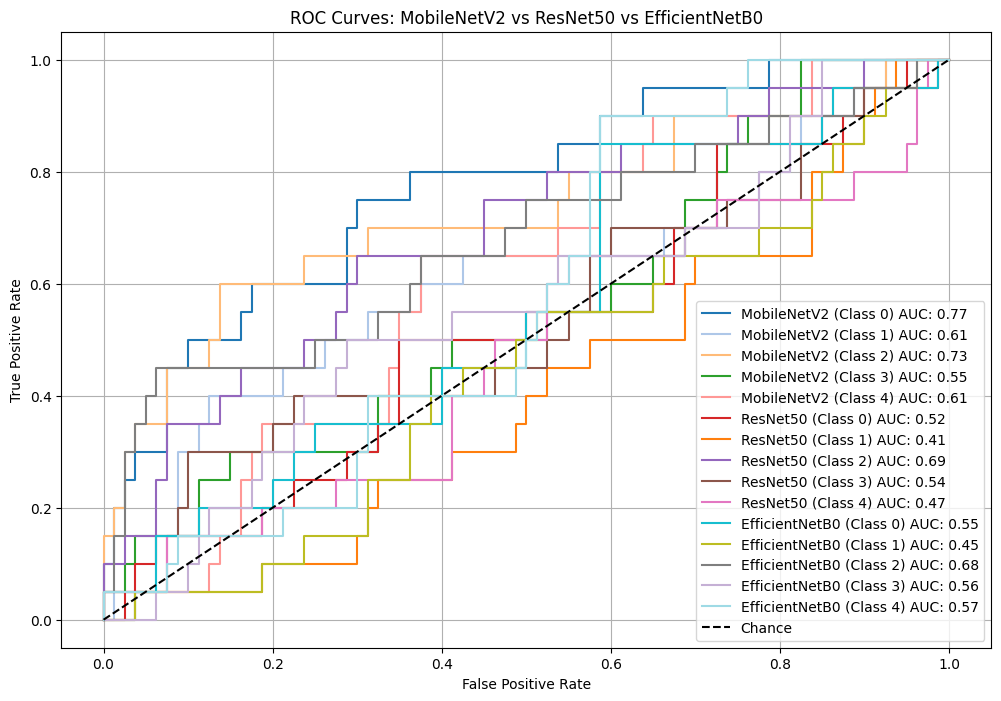

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

def plot_roc_curves(y_true_onehot, y_probs, label, color_list):
    for i in range(5):  # 5 classes
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (Class {i}) AUC: {roc_auc:.2f}', color=color_list[i])

plt.figure(figsize=(12, 8))

plot_roc_curves(true_labels_onehot, baseline_probs, "MobileNetV2", ['#1f77b4','#aec7e8','#ffbb78','#2ca02c','#ff9896'])
plot_roc_curves(true_labels_onehot, resnet_probs, "ResNet50", ['#d62728','#ff7f0e','#9467bd','#8c564b','#e377c2'])
plot_roc_curves(true_labels_onehot, eff_probs, "EfficientNetB0", ['#17becf','#bcbd22','#7f7f7f','#c5b0d5','#9edae5'])

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title("ROC Curves: MobileNetV2 vs ResNet50 vs EfficientNetB0")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

print("MobileNetV2 Accuracy:", accuracy_score(true_labels, baseline_preds))
print("ResNet50 Accuracy:", accuracy_score(true_labels, resnet_preds))
print("EfficientNetB0 Accuracy:", accuracy_score(true_labels, eff_preds))


MobileNetV2 Accuracy: 0.34
ResNet50 Accuracy: 0.2
EfficientNetB0 Accuracy: 0.2
